In [2]:
# %%

import torch
import einops
import sys

name_to_model_map = {
    "qwen-1.5b": ["Qwen/Qwen2.5-Math-1.5B", "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B"],
    "qwen-7b": ["Qwen/Qwen2.5-Math-7B", "deepseek-ai/DeepSeek-R1-Distill-Qwen-7B"],
    "qwen-14b": ["Qwen/Qwen2.5-14B", "deepseek-ai/DeepSeek-R1-Distill-Qwen-14B"],
}

target_name = "wait"
random_ablate = False
amplify = False

target_token_map = {
    "wait" : [" wait", "Wait"],
    "deductive": ["Therefore", "Thus"],
    "alternative": ["Alternatively"],
    "contrastive": ["However", "But"]
}

target_token_count = {
    "wait": 3605,
    "deductive": 1275,
    "alternative": 1507,
    "contrastive": 2357,
}

weight_path = "../checkpoints/version_0/qwen-1.5b_6.pt"
weights = torch.load(weight_path)

base_dec = weights["W_dec"][:, 0, :]
reasoning_dec = weights["W_dec"][:, 1, :]
base_norms = torch.norm(base_dec, p=1, dim=1)
reasoning_norms = torch.norm(reasoning_dec, p=1, dim=1)

relative_norms = reasoning_norms / base_norms
normalized_relative_norms = relative_norms / (1 + relative_norms)

/tmp/ipykernel_52925/1380579417.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load(weight_path)


In [34]:
import sys
sys.path.append("../")

from crosscoder_diff.utils import load_open_reasoning_tokens
all_tokens = load_open_reasoning_tokens()


# %%
from transformer_lens import HookedTransformer, ActivationCache

import os
os.environ['HF_HOME'] = '/om2/user/dbaek/.cache/'

device = "cuda" if torch.cuda.is_available() else "cpu"

save_name = "qwen-1.5b"

name_to_model_map = {
    "qwen-1.5b": ["Qwen/Qwen2.5-Math-1.5B", "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B"],
    "qwen-7b": ["Qwen/Qwen2.5-Math-7B", "deepseek-ai/DeepSeek-R1-Distill-Qwen-7B"],
    "qwen-14b": ["Qwen/Qwen2.5-14B", "deepseek-ai/DeepSeek-R1-Distill-Qwen-14B"],
}


from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(name_to_model_map[save_name][0])


base_model = HookedTransformer.from_pretrained(
    name_to_model_map[save_name][0],
    device=device, 
)

chat_model = HookedTransformer.from_pretrained(
    name_to_model_map[save_name][1],
    device=device,
)
hook_point = f"hook_embed"

Loading reasoning tokens from disk


/weka/scratch/weka/tegmark/dbaek/deepseek-diff/src/../crosscoder_diff/utils.py:244: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



Loaded pretrained model Qwen/Qwen2.5-Math-1.5B into HookedTransformer


Loaded pretrained model deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B into HookedTransformer


In [13]:
prompt_list = [chr(ord('A') + i) for i in range(ord('Z') - ord('A') + 1)]
print(prompt_list)
prompt_list = [str(i) for i in range(1, 10)]

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


[0.2883813  0.20653793]
[0.23699059 0.2033628 ]


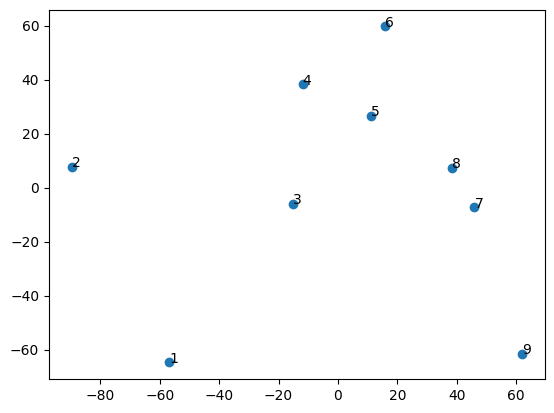

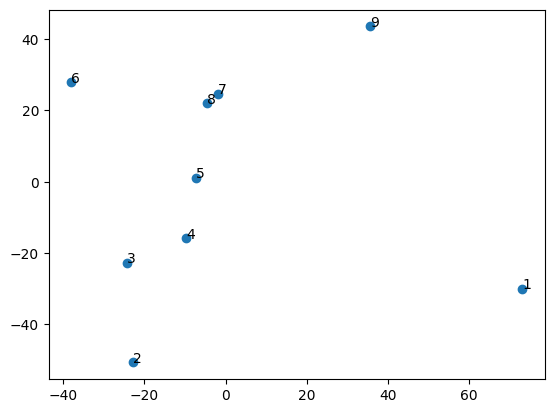

In [16]:
with torch.no_grad():
    _, cache_A = base_model.run_with_cache(prompt_list, names_filter=hook_point)
    _, cache_B = chat_model.run_with_cache(prompt_list, names_filter=hook_point)

    act_A = cache_A[hook_point][:, 0, :]
    act_B = cache_B[hook_point][:, 0, :]

from sklearn.decomposition import PCA
pca = PCA(n_components=2)

act_A_pca = pca.fit_transform(act_A.cpu().numpy())

import matplotlib.pyplot as plt
plt.scatter(act_A_pca[:, 0], act_A_pca[:, 1])
for i, txt in enumerate(prompt_list):
    plt.annotate(txt, (act_A_pca[i, 0], act_A_pca[i, 1]))

print(pca.explained_variance_ratio_)

plt.figure()
act_B_pca = pca.fit_transform(act_B.cpu().numpy())
plt.scatter(act_B_pca[:, 0], act_B_pca[:, 1])
for i, txt in enumerate(prompt_list):
    plt.annotate(txt, (act_B_pca[i, 0], act_B_pca[i, 1]))

print(pca.explained_variance_ratio_)


In [29]:
tokenizer2 = AutoTokenizer.from_pretrained(name_to_model_map[save_name][1])

In [31]:
tokenizer2

LlamaTokenizerFast(name_or_path='deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B', vocab_size=151643, model_max_length=16384, is_fast=True, padding_side='left', truncation_side='right', special_tokens={'bos_token': '<｜begin▁of▁sentence｜>', 'eos_token': '<｜end▁of▁sentence｜>', 'pad_token': '<｜end▁of▁sentence｜>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	151643: AddedToken("<｜end▁of▁sentence｜>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	151644: AddedToken("<｜User｜>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=False),
	151645: AddedToken("<｜Assistant｜>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=False),
	151646: AddedToken("<｜begin▁of▁sentence｜>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	151647: AddedToken("<|EOT|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=False),
	151648: AddedToken("<think>", rstrip=False

In [146]:
filename = "../abstractive/next_item.json"
hook_point = f"blocks.{base_model.cfg.n_layers // 2}.hook_resid_pre"
import json
with open(filename, "r") as f:
    data = json.load(f)
    
filtered_data = []
for i in range(len(data)):
    if len(tokenizer.encode(data[i]["input"])) == 1 and len(tokenizer.encode(data[i]["output"])) == 1:
        filtered_data.append(data[i]["input"])
        filtered_data.append(data[i]["output"])
        print(data[i]["input"], data[i]["output"])

torch.cuda.empty_cache()
with torch.no_grad():
    _, cache_A = base_model.run_with_cache(filtered_data, names_filter=hook_point)
    _, cache_B = chat_model.run_with_cache(filtered_data, names_filter=hook_point)

act_A = cache_A[hook_point][:, 0, :]
act_B = cache_B[hook_point][:, 0, :]

act_A_pca = pca.fit_transform(act_A.cpu().numpy())
act_B_pca = pca.fit_transform(act_B.cpu().numpy())

avg_norm = torch.norm(torch.vstack([act_A, act_B]), p=2, dim=1).mean().item()

act_A_avg_norm = np.linalg.norm(act_A_pca, axis=1).mean()
print(np.linalg.norm(act_A_pca, axis=1).shape)
act_B_avg_norm = np.linalg.norm(act_B_pca, axis=1).mean()
print(act_A_pca.shape, act_B_pca.shape)


zero one
one two
two three
three four
four five
five six
six seven
seven eight
eight nine
nine ten
0 1
1 2
2 3
3 4
4 5
5 6
6 7
7 8
8 9
a b
b c
c d
d e
e f
f g
g h
h i
i j
j k
k l
l m
m n
n o
o p
p q
q r
r s
s t
t u
u v
v w
w x
x y
y z
A B
B C
C D
D E
E F
F G
G H
H I
I J
J K
K L
L M
M N
N O
O P
P Q
Q R
R S
S T
T U
U V
V W
W X
X Y
Y Z
AA BB
BB CC
CC DD
DD EE
EE FF
FF GG
GG HH
HH II
II JJ
JJ KK
KK LL
LL MM
MM NN
NN OO
OO PP
PP QQ
QQ RR
RR SS
SS TT
TT UU
UU VV
VV WW
WW XX
XX YY
YY ZZ
aa bb
bb cc
cc dd
dd ee
ee ff
ff gg
gg hh
hh ii
ii jj
jj kk
kk ll
ll mm
mm nn
nn oo
oo pp
pp qq
qq rr
rr ss
ss tt
tt uu
uu vv
vv ww
ww xx
xx yy
yy zz
I II
II III
III IV
IV V
V VI
IX X
X XI
i ii
ii iii
iii iv
iv v
v vi
ix x
x xi
Monday Tuesday
Tuesday Wednesday
Wednesday Thursday
Thursday Friday
Friday Saturday
Saturday Sunday
January February
February March
March April
April May
May June
June July
July August
August September
September October
October November
November December
Sunday Monday
December January
(

In [143]:
import numpy as np

orig_norm_list = []
chat_norm_list = []
for i in range(len(filtered_data)//2):
    for j in range(i+1, len(filtered_data)//2):
        norm1 = np.linalg.norm(act_A_pca[2*i] - act_A_pca[2*i+1] - act_A_pca[2*j] + act_A_pca[2*j+1], ord=2)
        norm2 = np.linalg.norm(act_B_pca[2*i] - act_B_pca[2*i+1] - act_B_pca[2*j] + act_B_pca[2*j+1], ord=2)
        
        orig_norm_list.append(norm1 / act_A_avg_norm)
        chat_norm_list.append(norm2 / act_B_avg_norm)

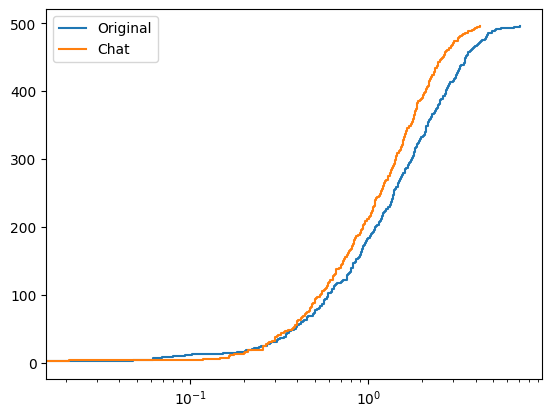

In [144]:
# Sort the data
sorted_data = np.sort(orig_norm_list)
sorted_chat_data = np.sort(chat_norm_list)

# Create an array of cumulative counts.
# Each value in sorted_data gets a count equal to its index (starting at 1)
cumulative_counts = np.arange(1, len(sorted_data) + 1)

plt.step(sorted_data, cumulative_counts, where='post', label="Original")
plt.step(sorted_chat_data, cumulative_counts, where='post', label="Chat")
plt.legend()
plt.xscale("log")

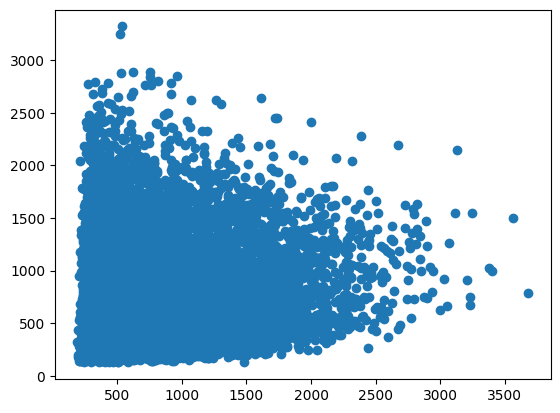

In [88]:
plt.scatter(orig_norm_list, chat_norm_list)